# <font color="forestgreen">Competition Introduction</font>
Given image dataset of different cells, the task to detect, localize all the nuclei (plural "nucleus") in the given image.

## <font color="Darkcyan">1) The Why?</font>
Imagine speeding up research for almost every disease, from lung cancer and heart disease to rare disorders. The 2018 Data Science Bowl offers our most ambitious mission yet: create an algorithm to automate nucleus detection.

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold. Want a snapshot about the 2018 Data Science Bowl? [View this video](https://www.youtube.com/watch?v=eHwkfhmJexs&feature=youtu.be)
<center><u>Source <a href="https://www.kaggle.com/competitions/data-science-bowl-2018/overview">Competition Overview page </a></u></center>

## <font color="Darkcyan">2) The How?</font>
Our training data is a bit challengy, & that's awesome! For each training example we have the full image of cell(s) and for each nucleus in the image we have the nuclei' mask individually seperated in its own file.

### <font color="forestgreen">2.1) Data Preprocessing</font>
Since our training data is quite low (~600 images) we will try to discard the less-important-highly-varied information found in images. Upon inspection (feel free to download the data and investigate via [this link](https://www.kaggle.com/competitions/data-science-bowl-2018/data)) images come in different colours, different illuminations, so... Let's discard this variations and enhance our image data through converting all the image into grayscale image, and later to Black and White images using some image processing techinques

### <font color="forestgreen">2.2) Training Process</font>
We will use the powerful `Convolutional Neural Networks` (**CNNs for short**) to train our image data, keeping in mind that we will use a state-of-the-art network titled [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

#### <font color="darkcyan">2.2.1) Why U-Net?</font>
U-Net (introduced in 2015) is quite powerful segmentation network especially when to it comes to limited training data (as per our case) *For more info check paper link provided*. **Why it's called U-Net?** Well give its architecture a look! (**Note: slightly modified than original paper**).
<center><img src="https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png" title="U-Net architecture" width=700/></center>
<center><u><a href="https://www.researchgate.net/figure/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al_fig2_323597886">Source: Research Gate</a></u></center>


## <font color="Darkcyan">3) Apporach</font>

In [1]:
# Importing phase
import numpy as np
import pandas as pd     
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Input
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [2]:
# data is in .zip files 
def unzipper(zipfile_loc, extract_loc):
    """Unzipping file using user-defined location"""
    with zipfile.ZipFile(zipfile_loc, 'r') as zip_ref:
        zip_ref.extractall(extract_loc)

In [3]:
# unzipping training data
unzipper(zipfile_loc="/kaggle/input/data-science-bowl-2018/stage1_train.zip",
         extract_loc="/kaggle/working/train/")

## ▣ Data Preprocessing

In [4]:
# getting images ids
train_stg1_id = os.listdir("/kaggle/working/train")
train_stg1_id = np.array(train_stg1_id)     # prefer to work with arrays

In [5]:
# getting training images
train_dir = "/kaggle/working/train/"
images = []
for i in range(train_stg1_id.shape[0]):
    img_path = os.path.join(train_dir, train_stg1_id[i], 'images/', train_stg1_id[i] + '.png')
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_AREA)       # unifying images sizes
    images.append(img)
    
# converting images to numpy array
images = np.array(images)

### Plotting sample training images

feel free to change the image id in `images[id]` variable to visualize different images.

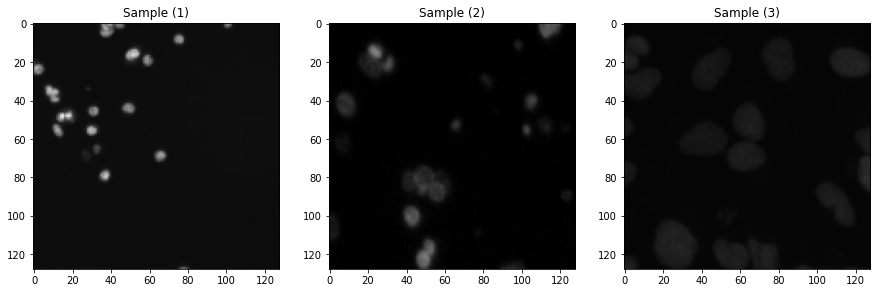

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
ax[0].imshow(images[0]), ax[0].set_title("Sample (1)")
ax[1].imshow(images[1]), ax[1].set_title("Sample (2)")
ax[2].imshow(images[2]), ax[2].set_title("Sample (3)");

In [7]:
# getting masks
masks = []
for i in range(train_stg1_id.shape[0]):    
    zeros = np.zeros((128, 128, 3))
    mask_locs = os.listdir(os.path.join(train_dir, train_stg1_id[i], 'masks/'))
    for j in range(len(mask_locs)):
        mask = cv2.imread(os.path.join(train_dir, train_stg1_id[i], 'masks/', mask_locs[j]))
        mask = cv2.resize(mask, dsize=(128, 128), interpolation=cv2.INTER_AREA)
        mask = np.array(mask)    # converting to arrays in order to add all masks together (B&W imgs)
        zeros = zeros + mask     # adding masks together
    masks.append(zeros)          # appending the whole added mask 
        
# converting to numpy array
masks = np.array(masks)

### Plotting sample training data with thier corresponding masks

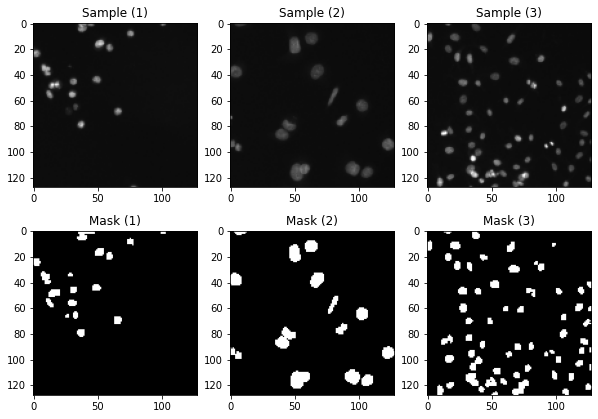

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
ax[0, 0].imshow(images[0]), ax[0, 0].set_title("Sample (1)")
ax[0, 1].imshow(images[100]), ax[0, 1].set_title("Sample (2)")
ax[0, 2].imshow(images[200]), ax[0, 2].set_title("Sample (3)")
ax[1, 0].imshow(masks[0]), ax[1, 0].set_title("Mask (1)")
ax[1, 1].imshow(masks[100]), ax[1, 1].set_title("Mask (2)")
ax[1, 2].imshow(masks[200]), ax[1, 2].set_title("Mask (3)");

### Images have High Variability
**As you can see images varies in cell type, magnification, coloring, ..etc.**. Converting images from colored to grey scale images will overcome this issue as well as enhance the data quality since coloring is not vital regarding our problem. Let's convert the coloring using `cv2.cvtColor()` method from [OpenCV](https://opencv.org/).

#### Starting with a sample for demonstration
Feel free to change `idx_tmp` variable **value** to see different image results.

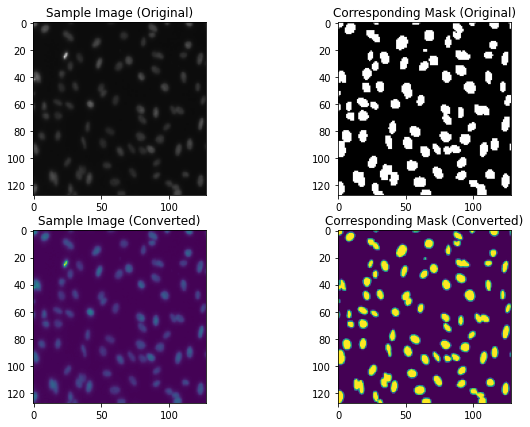

In [9]:
idx_tmp = 32
tmp1 = cv2.cvtColor(images[idx_tmp].astype('uint8'), cv2.COLOR_BGR2GRAY)
tmp2 = cv2.cvtColor(masks[idx_tmp].astype('uint8'), cv2.COLOR_BGR2GRAY)

# Plotting original and converted images & masks
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
ax[0, 0].imshow(images[idx_tmp]), ax[0, 0].set_title("Sample Image (Original)")
ax[0, 1].imshow(masks[idx_tmp]), ax[0, 1].set_title("Corresponding Mask (Original)")
ax[1, 0].imshow(tmp1), ax[1, 0].set_title("Sample Image (Converted)")
ax[1, 1].imshow(tmp2), ax[1, 1].set_title("Corresponding Mask (Converted)");

#### As you can see the input image is highly enhanced regardless of the image brightness.

In [10]:
# converting all images, masks
def color_2_gray(image):
    image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY)
    return image

# converting images
train_imgs = np.zeros((670, 128, 128))
for idx in range(images.shape[0]):
    train_imgs[idx] = color_2_gray(images[idx])
    
# converting masks
train_masks = np.zeros((670, 128, 128))
for idx in range(masks.shape[0]):
    train_masks[idx] = color_2_gray(masks[idx])

### Visualizing sample from the results
Feel free to change the `idx_tmp` variable **value** to see different images.

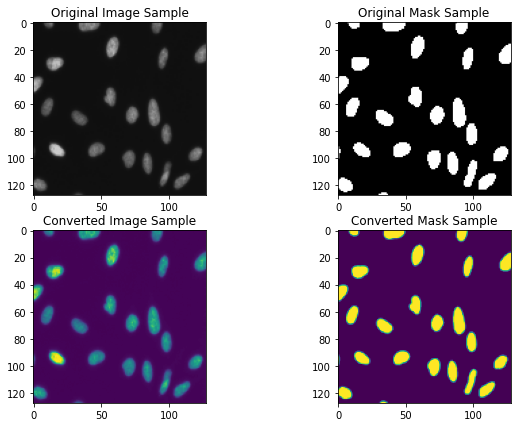

In [11]:
idx_tmp = 6
# showing results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
ax[0, 0].imshow(images[idx_tmp]), ax[0, 0].set_title("Original Image Sample")
ax[0, 1].imshow(masks[idx_tmp]), ax[0, 1].set_title("Original Mask Sample")
ax[1, 0].imshow(train_imgs[idx_tmp]), ax[1, 0].set_title("Converted Image Sample")
ax[1, 1].imshow(train_masks[idx_tmp]), ax[1, 1].set_title("Converted Mask Sample");

## ▻ Short summary I
- Input images are stored in *`images`* variable with their corresponding ids in *`train_stg1_id`* variable as well as their corresponding masks in *`masks`* variable.
- Masks are **aggregated together** in one **altogether masks** image **for each** training image.
- All *`images`* and *`masks`* are **color converted** into **greyscale** color format.

 ## ▣ Training Process

In [12]:
# Data preparation
X, y = train_imgs, train_masks

# Data splitting
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)

# Normalization
X_train, X_valid = X_train / 255, X_valid / 255      # images
y_train, y_valid = y_train / 255, y_valid / 255      # masks

## U-Net Model Building

In [13]:
def unet_model(input_layer, start_neurons, dropout_value):
    """Building the U-Net architecture"""
    # Encoder
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.5 * dropout_value)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout_value)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout_value)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_value)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    # Decoder
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_value)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout_value)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout_value)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout_value)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    # Output layer
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    model = Model(inputs=input_layer, outputs=[output_layer])
    return model

In [14]:
input_layer = Input((128, 128, 1))
model = unet_model(input_layer, 16, dropout_value=0.5)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(2), 'accuracy'])
model.summary()

2022-10-09 13:02:57.650074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 13:02:57.735436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 13:02:57.736242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 13:02:57.737844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
# Adding callbacks to stop learning when some conditions are met
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),   # reduce learning rate when metric stops improving 
    EarlyStopping(patience=10, verbose=1)                                    # Stop learning when metric stopped improving
]

In [16]:
# Training model
results = model.fit(X_train, y_train, batch_size=32,
                    epochs=200, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

2022-10-09 13:03:00.485978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-10-09 13:03:02.993247: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


16/16 [==============================] - 11s 131ms/step - loss: 0.5950 - mean_io_u: 0.4442 - accuracy: 0.7941 - val_loss: 0.4702 - val_mean_io_u: 0.4412 - val_accuracy: 0.8304
Epoch 2/200
16/16 [==============================] - 1s 52ms/step - loss: 0.4218 - mean_io_u: 0.4442 - accuracy: 0.8342 - val_loss: 0.4069 - val_mean_io_u: 0.4412 - val_accuracy: 0.8304
Epoch 3/200
16/16 [==============================] - 1s 53ms/step - loss: 0.3807 - mean_io_u: 0.4442 - accuracy: 0.8342 - val_loss: 0.3513 - val_mean_io_u: 0.4412 - val_accuracy: 0.8304
Epoch 4/200
16/16 [==============================] - 1s 52ms/step - loss: 0.3122 - mean_io_u: 0.4442 - accuracy: 0.8342 - val_loss: 0.2932 - val_mean_io_u: 0.4412 - val_accuracy: 0.8304
Epoch 5/200
16/16 [==============================] - 1s 52ms/step - loss: 0.2682 - mean_io_u: 0.4442 - accuracy: 0.8342 - val_loss: 0.2692 - val_mean_io_u: 0.4412 - val_accuracy: 0.8304
Epoch 6/200
16/16 [==============================] - 1s 52ms/step - loss: 0.2499

## Visualizing results

In [17]:
model.evaluate(X_valid, y_valid);                  # Best weights achieved

6/6 [==============================] - 0s 15ms/step - loss: 0.0855 - mean_io_u: 0.4412 - accuracy: 0.9313


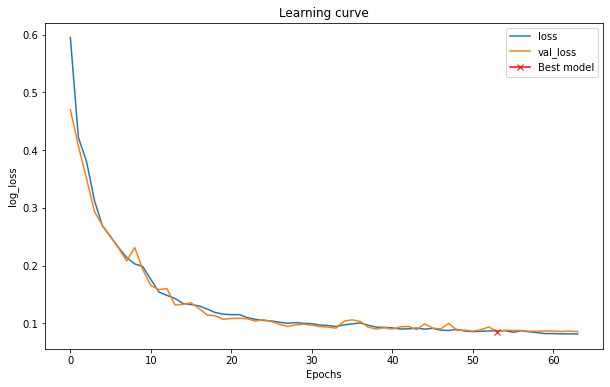

In [18]:
# Plotting learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]),
         marker="x", color="r", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Plotting results on training and/or validation data

In [19]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

In [20]:
def plot_sample(X, y, preds, ix=None):
    """Function to plot the results on given individual sample"""
    if ix is None:
        ix = random.randint(0, len(X))     # show random sample if no index provided

    has_mask = y[ix].max() > 0             # checking for any found masks

    # Configuring our plots
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sample Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Gound Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')

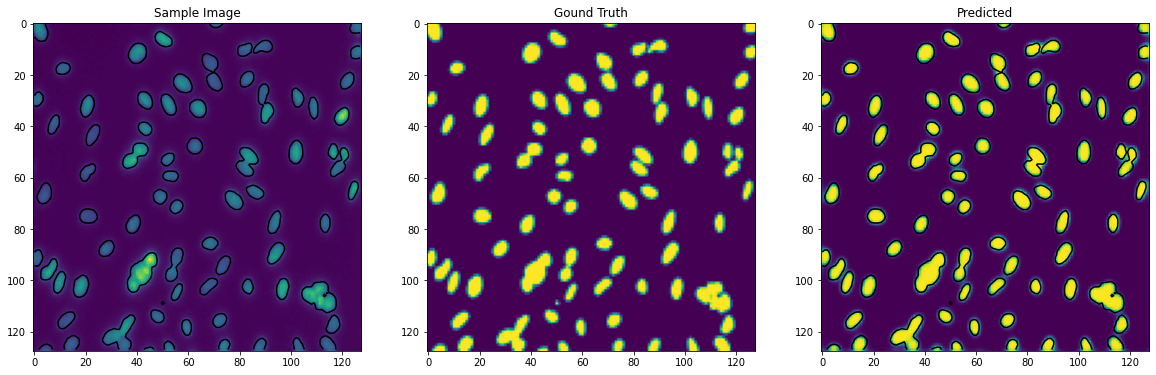

In [21]:
plot_sample(X_train, y_train, preds_train, ix=14)

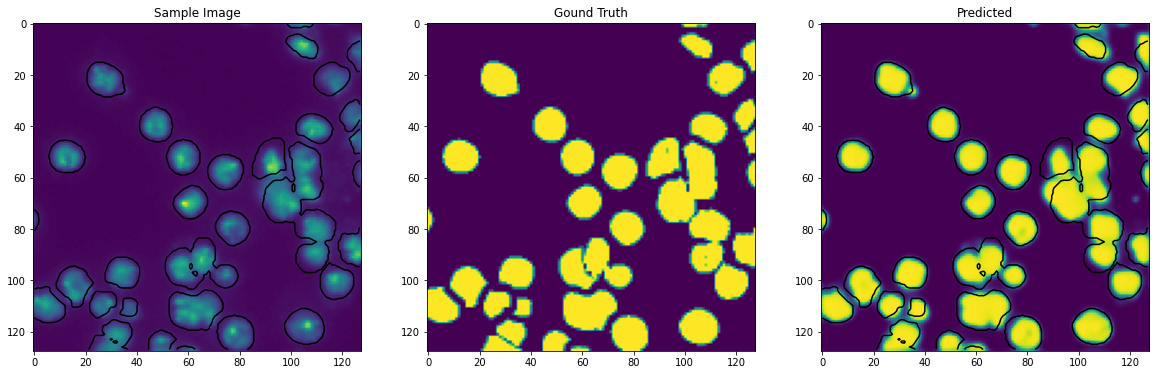

In [22]:
plot_sample(X_train, y_train, preds_train, ix=6)

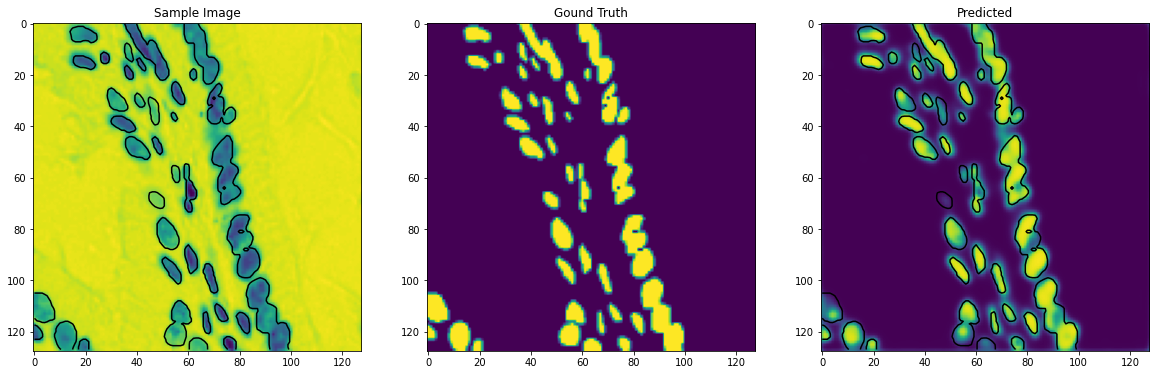

In [23]:
plot_sample(X_train, y_train, preds_train, ix=12)

## ▻ Short Summary II
- Our `model` has been trained on given data.
- At first glance we have no "visible" signs of underfitting or overfitting (from learning curve), so overall the model trained quite well.